In [1]:
import pandas as pd
import numpy as np
import imblearn
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [2]:
data_random = pd.read_csv('../data/random.dat', names=['C1', 'C3', 'bq', 'likelihood'])
data_plot = pd.read_csv('../data/plotdata.csv')

In [3]:
drandom = data_random.loc[data_random['likelihood']>-50]
dplot = data_plot.loc[data_plot['likelihood']>-50]

In [4]:
data = pd.concat([drandom, dplot], ignore_index=True)

We will oversample the data with medium likelihood, because they are too few points in this range

In [5]:
groups = []
for i in data.index:
    if data['likelihood'][i] < 16:
        groups.append(0)
    elif data['likelihood'][i] < 18:
        groups.append(1)
    #elif drandom['likelihood'][i] < 20:
    #    groups.append(2)
    else:
        groups.append(3)

groups = pd.Series(groups, index=data.index)

In [6]:
sm = imblearn.over_sampling.SMOTE()
dataset, ysmote = sm.fit_resample(data, groups)

In [7]:
import sklearn.model_selection


training, validation = sklearn.model_selection.train_test_split(dataset)

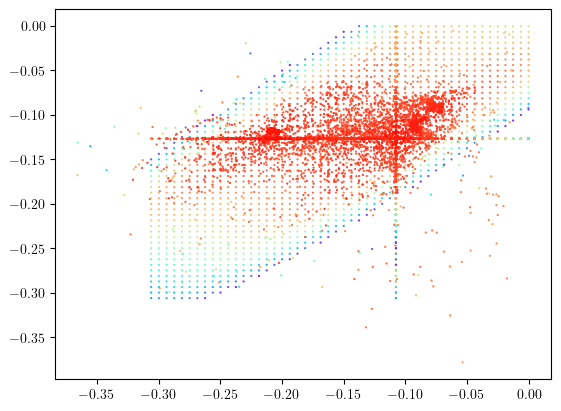

In [8]:
plt.scatter(dataset['C1'], dataset['C3'], c=dataset['likelihood'], cmap='rainbow', s=0.3)

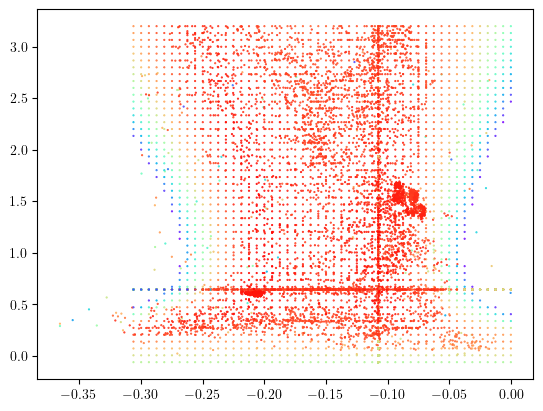

In [9]:
plt.scatter(dataset['C1'], dataset['bq'], c=dataset['likelihood'], cmap='rainbow', s=0.3)

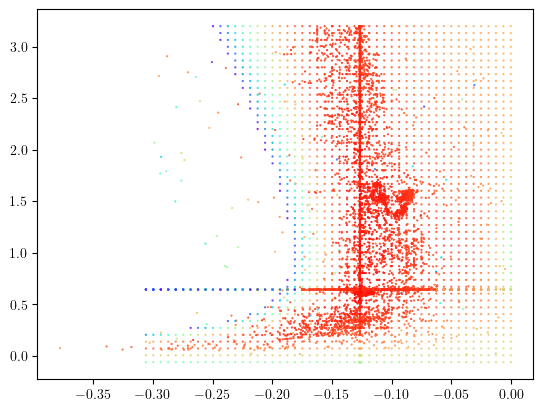

In [10]:
plt.scatter(dataset['C3'], dataset['bq'], c=dataset['likelihood'], cmap='rainbow', s=0.3)

In [11]:
trainX = training[['C1', 'C3', 'bq']]

In [12]:
trainY = training['likelihood']

In [13]:
valX = validation[['C1', 'C3', 'bq']]
valY = validation['likelihood']

In [14]:
import xgboost

In [15]:
import xgboost.callback


earlystop = xgboost.callback.EarlyStopping(5, data_name='validation_0', save_best=True)

xr = xgboost.XGBRegressor(n_estimators=3000, callbacks=[earlystop], learning_rate=0.03)
xr.fit(trainX, trainY, eval_set=[(valX, valY)])

[0]	validation_0-rmse:16.94431
[1]	validation_0-rmse:16.52412
[2]	validation_0-rmse:16.11717
[3]	validation_0-rmse:15.72527
[4]	validation_0-rmse:15.34430
[5]	validation_0-rmse:14.97321
[6]	validation_0-rmse:14.62058
[7]	validation_0-rmse:14.27304
[8]	validation_0-rmse:13.94431
[9]	validation_0-rmse:13.61889
[10]	validation_0-rmse:13.30294
[11]	validation_0-rmse:13.00104
[12]	validation_0-rmse:12.70772
[13]	validation_0-rmse:12.43124
[14]	validation_0-rmse:12.15662
[15]	validation_0-rmse:11.89444
[16]	validation_0-rmse:11.64079
[17]	validation_0-rmse:11.39769
[18]	validation_0-rmse:11.16676
[19]	validation_0-rmse:10.93401
[20]	validation_0-rmse:10.71543
[21]	validation_0-rmse:10.49575
[22]	validation_0-rmse:10.29740
[23]	validation_0-rmse:10.09464
[24]	validation_0-rmse:9.89673
[25]	validation_0-rmse:9.70769
[26]	validation_0-rmse:9.53641
[27]	validation_0-rmse:9.36500
[28]	validation_0-rmse:9.19421
[29]	validation_0-rmse:9.02371
[30]	validation_0-rmse:8.86643
[31]	validation_0-rmse:8.

XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x7f44dcfeb9d0>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [16]:
xr.save_model('xgboost_scIII.json')

/home/jorge/.cache/pypoetry/virtualenvs/banomalies-ml-24-q3wM3yKA-py3.10/lib64/python3.10/site-packages/xgboost/sklearn.py:761: UserWarning: callbacks is not saved in Scikit-Learn meta.
  warnings.warn(


In [17]:
def predict_point(C1, C3, bq):
    if C1 > 0:
        fC1 = np.exp(C1*50)-1
    elif C1 < -0.3:
        fC1 = np.exp((-C1-0.3)*50)-1
    else:
        fC1 = 0.0
    if C3 > 0:
        fC3 = np.exp(C3*50)-1
    elif C3 < -0.3:
        fC3 = np.exp((-C3-0.3)*50)-1
    else:
        fC3 = 0.0
    if bq < 0:
        fbq = np.exp(-bq*50)-1
    elif bq > 3.2:
        fbq = np.exp((bq-3.2)*50)-1
    else:
        fbq = 0.0
    return xr.predict(pd.DataFrame([{'C1': C1, 'C3': C3, 'bq': bq},]))[0]-fC1-fC3-fbq